<a href="https://colab.research.google.com/github/sjeena0722/3-min-pytorch/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

##  하이퍼파라미터

In [ ]:
EPOCHS     = 300
BATCH_SIZE = 128

## 데이터셋 불러오기

* CIFAR-10 데이터셋
* 32x32 크기의 컬러 이미지 6만개
* 자동차, 새, 고양이, 사슴 등 10가지 class 존재

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data', # CIFAR 10 데이터 불러오기
                   train=True,
                   download=True,
                   transform=transforms.Compose([ # 과적합을 방지하기 위해 RandomCrop과 RandomHorizontalFlip과 같은 noise를 추가
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./.data/cifar-10-python.tar.gz to ./.data


## ResNet 모델 만들기

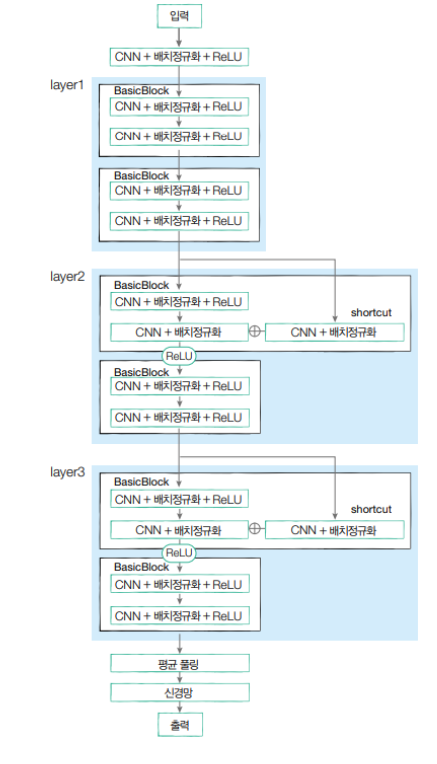


In [ ]:
 class BasicBlock(nn.Module): # ResNet을 구성하는 기본 블럭
     # CNN + Batch Normalizaiton + ReLU  
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        #  배치 정규화(batch normalization)을 수행
        # 자체적으로 정규화를 수행해 드롭아웃과 같은 효과

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # nn.Sequential()은 여러 모듈(nn.Module)을 하나의 모듈로 엮는 역할
        # 두번째 블록 부터는 in_planes()를 받아 self.bn2 계층과 출력크기가 같은 planes를 더해주는 self.shortcut모듈을 정의

        if stride != 1 or in_planes != planes: # Conv + BN
        # stride가 1이 아니라서 크기가 줄어들 경우 혹은 self.inplanes가 planes의 크기와 맞지 않을 때, conv1x1에 1이 아닌 stride를 가진 레이어로 downsampling함
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # 입력x가 컨볼루션, 배치정규화, 활성화 함수를 거침
        out = self.bn2(self.conv2(out)) # 다음 컨볼루션, 배치정규화를 거침
        out += self.shortcut(x)  # 입력 x를 self.shortcut을 거치게 하여 크기를 같게하고 더해줌
        out = F.relu(out) # 활성화함수를 통과시켜 최종출력 만듦
        return out



#  실제 ResNet 모델 정의 클래스
#  BasicBlock 클래스는 self._make_layer() 함수를 통해 하나의 모듈로 객체화되어 ResNet 모델의 주요 층을 이룸
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16 
        # self.in_planes 변수는 _make_layer 함수가 층을 만들 때 전 층의 채널 출력값을 기록하는데 쓰임
        # layer1이 입력받는 채널의 개수가 16개이므로 16으로 초기화

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)  # 출력 텐서 : 16x32x32
        self.layer2 = self._make_layer(32, 2, stride=2)  # 출력 텐서 : 32x16x16
        self.layer3 = self._make_layer(64, 2, stride=2)  # 출력 텐서 : 64x8x8
        #self._make_layer()는 nn.Sequential의 도구로 여러 BasicBlock 모듈을 하나로 묶어주는 역할
        # self.layer1~3은 컨볼루션 계층과 마찬가지로 모듈(nn.Module)로 취급

        # layer1 : 16채널에서 16채널을 보내는 BasicBlock 2개
        # layer2 : 16채널을 받아 32채널을 출력하는 BasicBlock 1개와 32채널에서 32채널을 내보내는 BasicBlock 1개
        # layer3 : 32채널을 받아 64채널을 출력하는 BasicBlock 1개와 64채널에서 64채널을 출력하는 BasicBlock 1개
        # 16->32, 32->64로 증가되는 Basic Block은 shortcut 모듈 보유

        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
      # _make_layer 함수 : 파이토치의 nn.Sequential()의 도구로, BasicBlock을 모듈 하나로 묶어주는 역할
      # _make_layer 함수는 self.in_planes 채널 개수로부터 직접 입력받은 인수인 planes 채널 개수만큼을 출력하는 BasicBlock을 생성
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) #x: 3x32x32
        out = self.layer1(out) # 출력 텐서 : 16x32x32
        out = self.layer2(out) # 출력 텐서 : 32x16x16
        out = self.layer3(out) # 출력 텐서 : 64x8x8
        out = F.avg_pool2d(out, 8) # average pooling => 원소의 개수 64개
        out = out.view(out.size(0), -1)
        out = self.linear(out) # label 10개마다 예측값 생성
        return out

## 준비


In [ ]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# 에폭마다 호출되며 step_size를 50으로 지정해 50번 호출될 때 학습률에 0.1(gamma)만큼 곱함
# 0.1로 시작한 학습률은 50에폭 이후에 0.1 x 0.1 = 0.01로 낮아짐 => 더 정교하게 최적화

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

## 학습하기

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 테스트하기

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 코드 돌려보기

In [ ]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step()  # scheduler.step()으로 학습률을 조금 낮춰주는 단계가 추가
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1] Test Loss: 1.5139, Accuracy: 46.31%
[2] Test Loss: 1.2233, Accuracy: 57.80%
[3] Test Loss: 1.1102, Accuracy: 63.13%
[4] Test Loss: 1.0025, Accuracy: 67.09%
[5] Test Loss: 0.8006, Accuracy: 72.79%
[6] Test Loss: 0.9182, Accuracy: 70.20%
[7] Test Loss: 1.0312, Accuracy: 67.37%
[8] Test Loss: 0.7972, Accuracy: 73.91%
[9] Test Loss: 0.8377, Accuracy: 71.27%
[10] Test Loss: 0.8923, Accuracy: 71.45%
[11] Test Loss: 0.8335, Accuracy: 73.31%
[12] Test Loss: 0.7261, Accuracy: 75.73%
[13] Test Loss: 0.7722, Accuracy: 73.76%
[14] Test Loss: 0.6524, Accuracy: 77.09%
[15] Test Loss: 0.6766, Accuracy: 77.10%
[16] Test Loss: 0.6737, Accuracy: 77.09%
[17] Test Loss: 0.7457, Accuracy: 75.98%
[18] Test Loss: 0.7711, Accuracy: 75.57%
[19] Test Loss: 0.8879, Accuracy: 72.66%
[20] Test Loss: 0.6348, Accuracy: 78.73%
[21] Test Loss: 0.7589, Accuracy: 74.89%
[22] Test Loss: 0.7029, Accuracy: 76.49%
[23] Test Loss: 0.6839, Accuracy: 76.66%
[24] Test Loss: 0.6105, Accuracy: 79.57%
[25] Test Loss: 0.6884, A

* 성능은 90% 정도
* CIFAR-10은 성능을 충분히 올리기엔 비교적 작은 데이터셋이기 때문
* 더 큰 데이터셋을 사용하여 학습 데이터를 늘리면 오차가 훨씬 작아짐

In [ ]:
strides = [1]+[1]
for stride in strides:
  print(stride)

1
1


In [ ]:
strides = [2]+[1]
for stride in strides:
  print(stride)


2
1
